In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Load the dataset
file_path = 'Bitcoin Historical Data.csv'
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)
df = df.sort_index()
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['Price'] = df['Price'].interpolate(method='linear')

# Extract the 'Price' column
price_data = df['Price'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price_data)

# Prepare the data
lookback = 60
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# Split the data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Hyperparameter tuning for XGBoost
xgb = XGBRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=10, cv=3, verbose=2, n_jobs=-1)
random_search.fit(X_train, y_train)

# Best model after hyperparameter tuning
best_model = random_search.best_estimator_

# Make predictions
predicted_prices = best_model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [2]:
# Define function to evaluate metrics

def evaluate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-10))) * 100
    r2 = r2_score(y_true, y_pred)
    return rmse, mse, mae, mape, r2

# Evaluate metrics for 3-day, 7-day, and 30-day predictions
for days in [3, 7, 30]:
    metrics = evaluate_metrics(actual_prices[:days], predicted_prices[:days])
    print(f"\nEvaluation for {days}-day Prediction:")
    print(f"RMSE: {metrics[0]}")
    print(f"MSE: {metrics[1]}")
    print(f"MAE: {metrics[2]}")
    print(f"MAPE: {metrics[3]}%")
    print(f"R²: {metrics[4]}")


Evaluation for 3-day Prediction:
RMSE: 1101.2606173961638
MSE: 1212774.9474277797
MAE: 869.032031250002
MAPE: 1.7552116176838277%
R²: -1.2323230934528695

Evaluation for 7-day Prediction:
RMSE: 1338.688553456882
MSE: 1792087.0431564788
MAE: 956.4983258928581
MAPE: 1.8802155241145642%
R²: 0.030886253656733698

Evaluation for 30-day Prediction:
RMSE: 3474.8823018792154
MSE: 12074807.011913395
MAE: 2439.1148697916665
MAPE: 3.9046161469577947%
R²: 0.7759813033375169


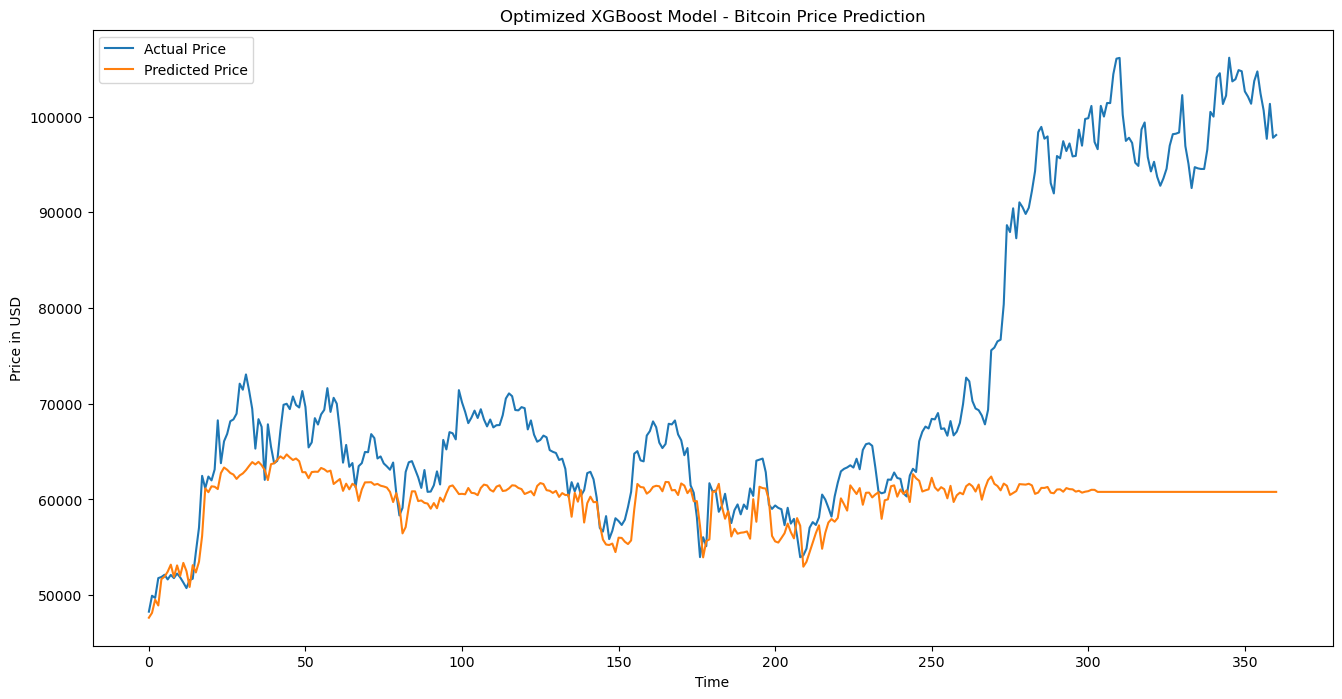

In [4]:

# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title('Optimized XGBoost Model - Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.legend()
plt.show()
